# Volcano finder with photutils

Tests out the functionality of photutils.psf and photutils.detection to find sources in LBTI images

Current status: this works great, but the navigation solutions do not work well. To do:
- make by-eye images for Imke
- make average of all the frames and hope nav solution works better with higher SNR
- Remove disk and all volcanoes, run through an optimizer fitting for the disk x, y, flux, ld

In [361]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import paths
from photutils.psf import (BasicPSFPhotometry, IterativelySubtractedPSFPhotometry, DAOGroup)
from photutils.detection import StarFinder
from photutils.background import BiweightLocationBackground
from astropy.io import fits
from astropy.table import Table, vstack
from scipy.interpolate import RegularGridInterpolator
from astropy.modeling.fitting import (TRFLSQFitter, LevMarLSQFitter, DogBoxLSQFitter, SimplexLSQFitter)

In [362]:
# load the PSF from make-psf.ipynb
with open(paths.data / 'psf_fittable_model.pkl', 'rb') as f:
    epsf = pickle.load(f)
print(type(epsf))

# load the data cube
io_hdul = fits.open(paths.data / 'lucky_nav.fits')
io_data = io_hdul[0].data

<class 'photutils.psf.models.EPSFModel'>
Name: EPSFModel (FittableImageModel)
N_inputs: 2
N_outputs: 1
Fittable parameters: ('flux', 'x_0', 'y_0')


## Get Emakong (and other) locations with photutils

In [363]:
# instantiate a star finder and group maker
separation_dist = 20 #input to photutils group_maker
crop_dist = 40 #crop to excise center of planet
thresh = 1.2*np.std(io_data)
star_finder = StarFinder(thresh, epsf.data) #threshold, kernel
group_maker = DAOGroup(separation_dist)
bkgd_estimator = BiweightLocationBackground()

# use these to do PSF fitting
source_extractor = IterativelySubtractedPSFPhotometry(
                group_maker, 
                bkgd_estimator, 
                epsf, epsf.data.shape, 
                star_finder)#,fitter = LevMarLSQFitter()) #tested all fitters, no difference

resids = []
result_tab = []
for i in range(io_data.shape[0]):
    ith_tab = source_extractor(image=io_data[i, crop_dist:-crop_dist, crop_dist:-crop_dist]) #excise center of planet; 
    result_tab.append(ith_tab)
    residual_image = source_extractor.get_residual_image()
    resids.append(residual_image)
    
# first source found is the brightest if using IterativelySubtractedPSFPhotometry
emakong_tab = vstack([j[0] for j in result_tab]) 

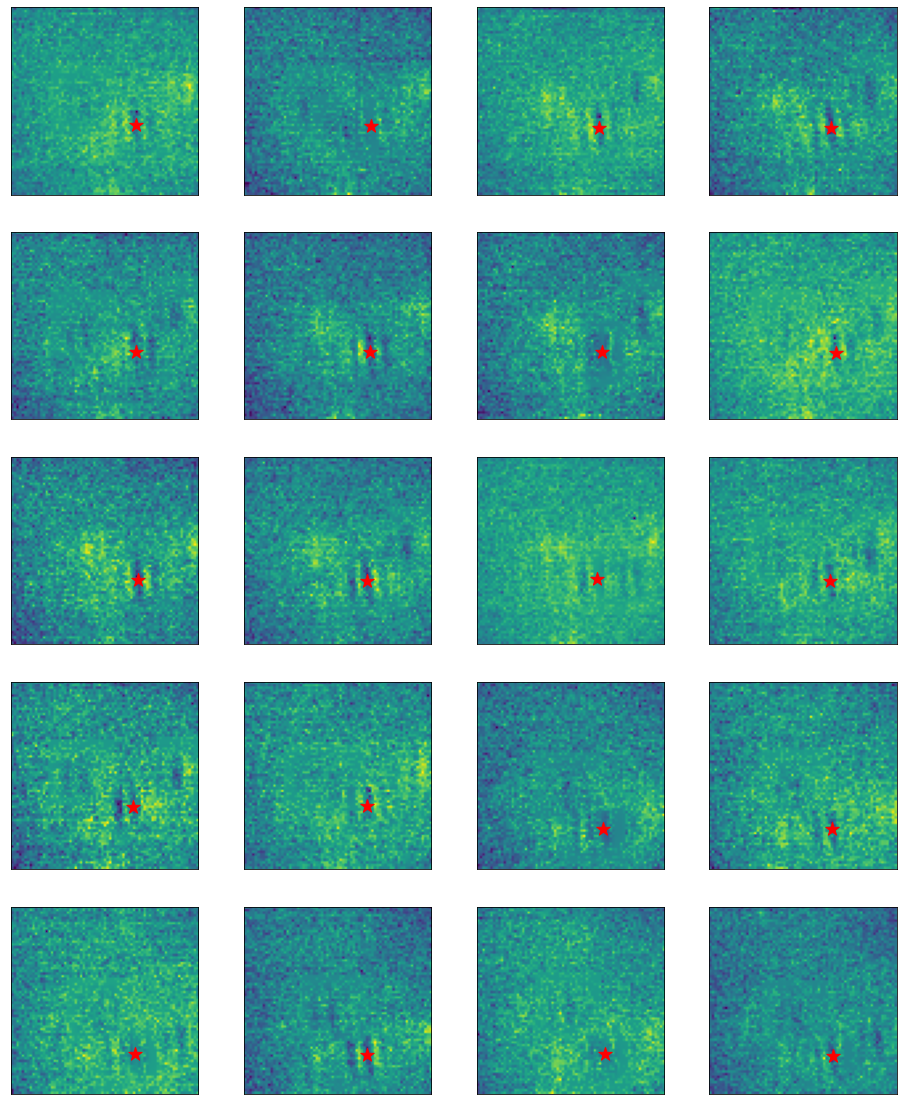

In [364]:
fig, axes = plt.subplots(5,4, figsize=(16,20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(resids[i], origin = 'lower')
    ax.scatter(emakong_tab[i]['x_fit'], emakong_tab[i]['y_fit'], color = 'red', marker = '*', s=200)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

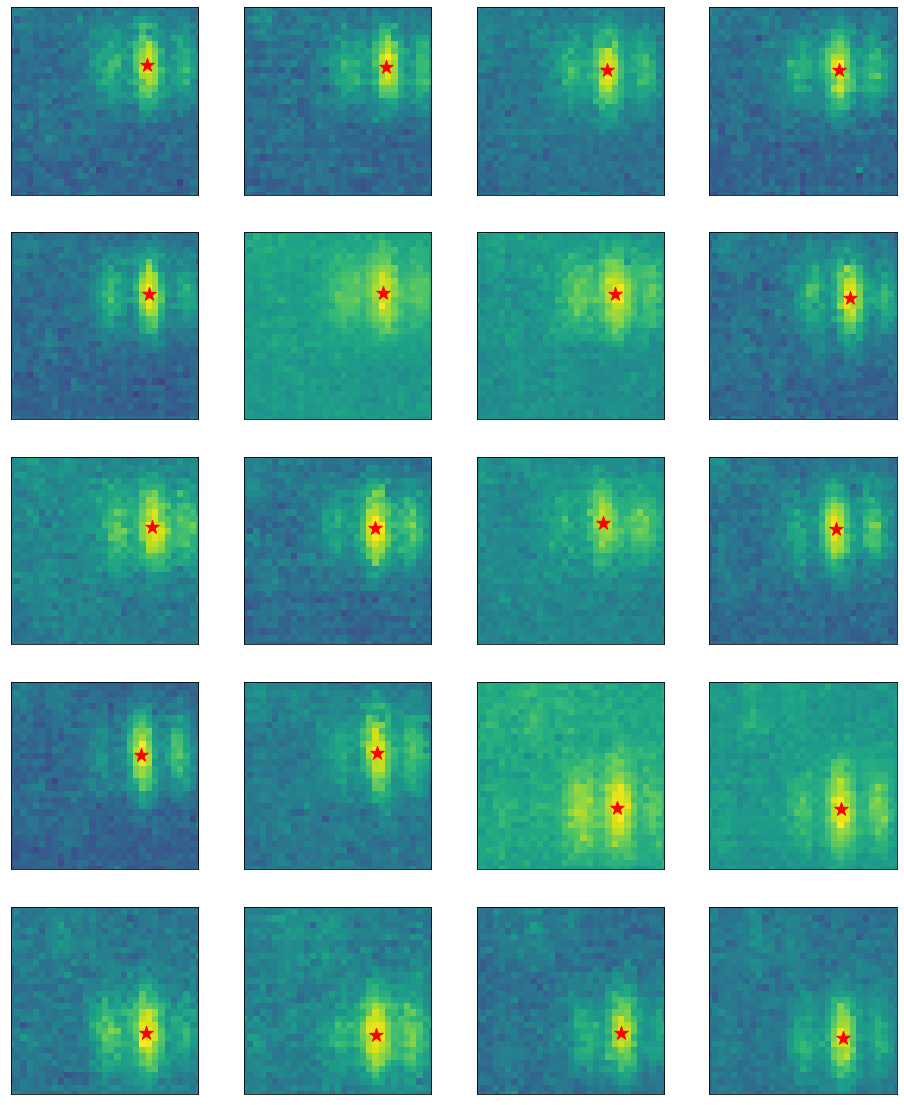

In [375]:
fig, axes = plt.subplots(5,4, figsize=(16,20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(io_data[i], origin = 'lower')
    ax.scatter(emakong_tab[i]['x_fit']+crop_dist, emakong_tab[i]['y_fit']+crop_dist, color = 'red', marker = '*', s=200)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([65, 95])
    ax.set_ylim([45, 75])
fig.savefig('diagnostic_plots/psf_fitting_thumbnails.png', dpi=300)
plt.show()

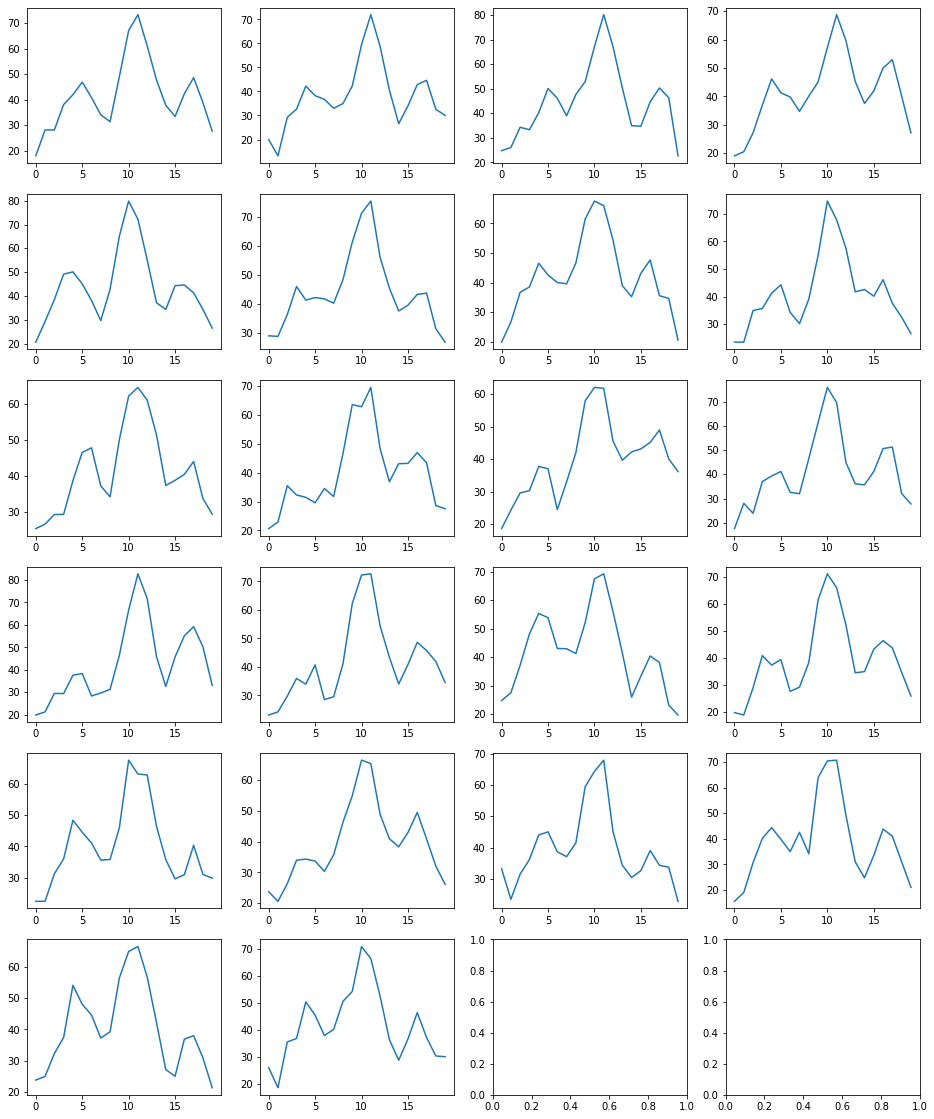

[0.8797709765404822, 0.8330037034254787, 0.8938042617866307, 0.7660338779685667, 1.032255407154882, 1.0057738645104701, 0.9727536447061671, 0.9007868580459061, 0.8754561117398175, 0.7398042977866123, 0.6947306302843622, 0.7837654054146476, 0.6378906642285773, 0.7641149577808931, 1.3650062320160985, 0.8092781616846703, 1.0374910736796399, 0.7517409277418166, 1.106467322394623, 0.9711139975814762, 1.2305781677955145, 1.0159443710358012]


In [374]:
# test if the fitter is sensitive to the relative brightness of the two wings
fig, axes = plt.subplots(6,4, figsize=(16,20))
left_right_index = []
for i in range(io_data.shape[0]):
    ax = axes.flatten()[i]
    xi = int(emakong_tab[i]['x_fit']+crop_dist)
    yi = int(emakong_tab[i]['y_fit']+crop_dist)
    data_cut = io_data[i,int(yi),xi-10:xi+10]
    idx = np.sum(data_cut[:6]) / np.sum(data_cut[-6:])
    left_right_index.append(idx)
    ax.plot(data_cut)
plt.show()
print(left_right_index)

In [367]:
print(result_tab[0]['x_fit', 'y_fit', 'flux_fit'])
print(emakong_tab['x_fit', 'y_fit', 'flux_fit'])

      x_fit              y_fit             flux_fit     
------------------ ------------------ ------------------
46.771724026965856 25.729938099719565 2540.0662989572456
27.192073155465284   34.9755084099167    569.40394517086
      x_fit              y_fit             flux_fit     
------------------ ------------------ ------------------
46.771724026965856 25.729938099719565 2540.0662989572456
 47.82987232651927   25.4654085017062 2569.0486880625026
45.855263191020576 24.859226103062092  2710.705415260633
  45.6825653606401 24.890436810738702 2646.9774583427165
 47.09824494954181   25.0202263693763 2805.9863905746397
 47.24718460889299 25.247669631706597 2676.0097214481957
 47.10203683231016  25.01230187847966  2638.523123450935
               ...                ...                ...
 46.12073278080184 14.727795834315438 2646.5828471285745
46.703583578183846 14.839010729450052  2548.159508678994
46.173214233729446 14.560631878297666 2545.0585347560905
48.185330565384994  14.80883519

## Translate Emakong positions onto lat-lon grids

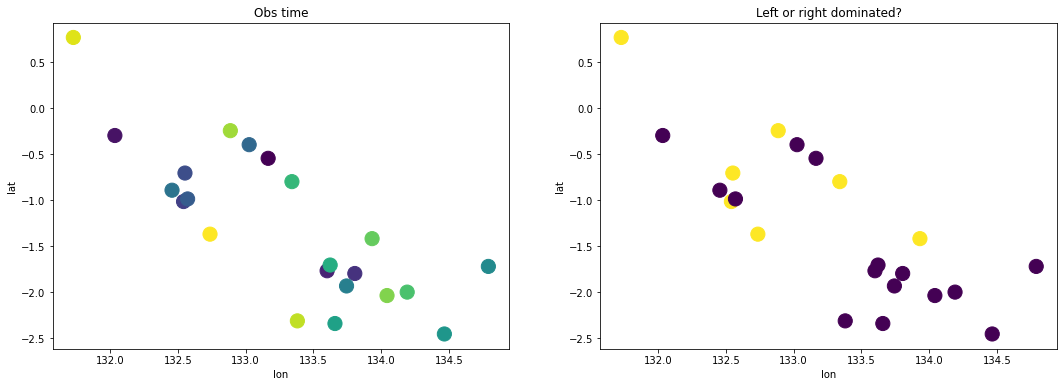

In [368]:
def latlon_interpf(lats):
    '''
    2-d cubic, curvature-minimizing interpolation for lat-lon grids
    see: scipy.interpolate.Regular2DInterpolator
    will only be valid when inputting x,y points with same shape as input lats (obviously)
    
    Parameters
    ----------
    lats: 2-D numpy array of latitudes or longitudes
    
    Returns
    -------
    interpf: interpolation function
    '''
    lats[np.isnan(lats)] = -999
    x = np.arange(lats.shape[0]) #add 1/2 so using center of each pixel?
    y = np.arange(lats.shape[1])
    interp = RegularGridInterpolator((x, y), lats)
    return interp

lats_cube = io_hdul[1].data
lons_cube = io_hdul[2].data

# interpolate lat-lon grids to find Emakong location
emakong_lat = []
emakong_lon = []
for i in range(lats_cube.shape[0]):
    
    loc = (emakong_tab[i]['y_fit']+crop_dist, emakong_tab[i]['x_fit']+crop_dist)
    lat_interp = latlon_interpf(lats_cube[i])
    lon_interp = latlon_interpf(lons_cube[i])
    lat_f = lat_interp(loc)
    lon_f = lon_interp(loc)
    #print(f'lat,lon at that location: {lat_f}, {lon_f}')
    
    emakong_lat.append(lat_f)
    emakong_lon.append(lon_f)
    

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (18, 6))
ax0.scatter(emakong_lon, emakong_lat, c=np.arange(lats_cube.shape[0]), s=200)
ax0.set_xlabel('lon')
ax0.set_ylabel('lat')
ax0.set_title('Obs time')

ax1.scatter(emakong_lon, emakong_lat, c=np.array(left_right_index)>1, s=200)
ax1.set_xlabel('lon')
ax1.set_ylabel('lat')
ax1.set_title('Left or right dominated?')
plt.show()

In [369]:
mean_lat = np.mean(emakong_lat)
lat_err = np.std(emakong_lat)
mean_lon = np.mean(emakong_lon)
lon_err = np.std(emakong_lon)
print(f'Emakong location is {mean_lat} N, {mean_lon} W +/- {lat_err, lon_err}')

Emakong location is -1.26925586279361 N, 133.28518488563077 W +/- (0.8092396754259721, 0.7725801429366445)


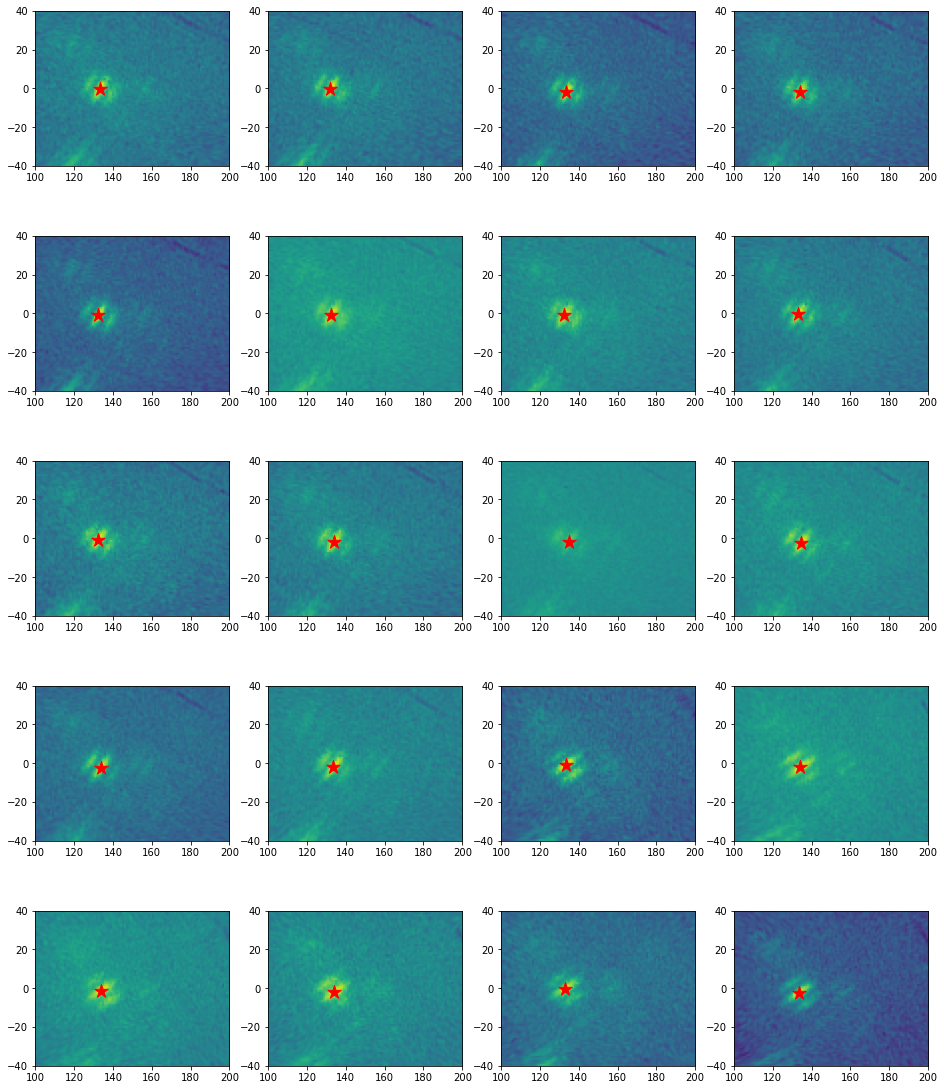

In [370]:
fig, axes = plt.subplots(5,4, figsize=(16,20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(io_hdul[4].data[i], origin = 'lower', extent=[0, 360, -90, 90])
    ax.scatter(emakong_lon[i], emakong_lat[i], color = 'red', marker = '*', s=200)
    ax.set_xlim([100, 200])
    ax.set_ylim([-40, 40])
plt.show()

## Look at all the other point sources that the algorithm found

['x_0', 'x_fit', 'y_0', 'y_fit', 'flux_0', 'flux_fit', 'id', 'group_id', 'flux_unc', 'x_0_unc', 'y_0_unc', 'iter_detected']


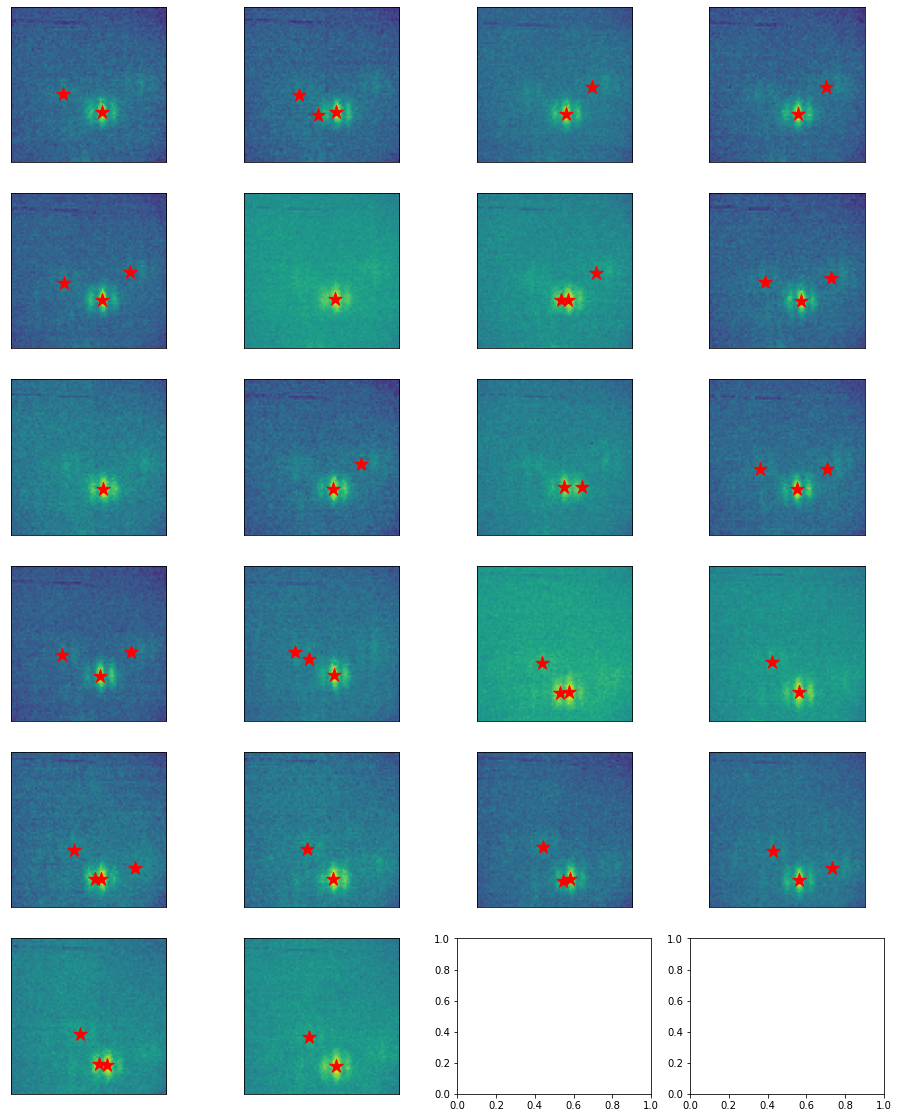

In [371]:
fig, axes = plt.subplots(6,4, figsize=(16,20))
print(result_tab[0].keys())
for i in range(len(result_tab)):
    results = result_tab[i]
    ax = axes.flatten()[i]
    ax.imshow(io_data[i], origin = 'lower')
    ax.scatter(results['x_fit']+crop_dist, results['y_fit']+crop_dist, color = 'red', marker = '*', s=200)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([40, 120])
    ax.set_ylim([40, 120])
plt.show()